In [1]:
import os
import itertools
from collections import Counter
import warnings
warnings.filterwarnings("ignore", message=".*set_ticklabels.*")
import statistics


from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.pipeline import FeatureUnion

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import mixup, write_pickled_object, cohen_d, aggregate_ranks
from utils import get_stats as get_stats_best
from utils import ProteinFeatureSelector, RNAFeatureSelector, MeanCenterer, ModalitySelector

/orcd/pool/005/hmbaghda/miniforge3/envs/metastatic_potential/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'
random_state = 42

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [3]:
res = pd.read_csv(os.path.join(data_path, 'interim', 
                               'pipeline_model_selection_joint_individual.csv'), index_col = 0)

rank_order = aggregate_ranks(
    opt_res=res.groupby('model_type', observed = True)[['test_mse', 'test_corr']].median().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'higher'
    },
    method = 'median'
)

rank_order

,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,Ridge,2.363023,0.522386,4.0,1.0,2.5,1.0
1,SVR_linear,2.331421,0.484991,3.0,3.0,3.0,3.0
2,SVR_poly,2.298017,0.473586,2.0,4.0,3.0,3.0
3,SVR_rbf,2.182403,0.455060,1.0,5.0,3.0,3.0
4,PLS,2.542905,0.491187,6.0,2.0,4.0,5.0
5,KNN,2.473228,0.344833,5.0,7.0,6.0,6.0
6,RFR,2.575841,0.398923,7.0,6.0,6.5,7.0
7,Lasso,2.638574,0.336096,9.0,8.0,8.5,8.5
8,ElasticNet,2.627370,0.314060,8.0,9.0,8.5,8.5


Tie-breaking ranks by standard deviation:

In [4]:
rank_order_std = aggregate_ranks(
    opt_res=res.groupby('model_type', observed = True)[['test_mse', 'test_corr']].std().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'lower'
    },
    method = 'median'
)
rank_order_std

,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,ElasticNet,0.578756,0.120993,3.0,1.0,2.0,1.5
1,SVR_rbf,0.557270,0.129508,2.0,2.0,2.0,1.5
2,Lasso,0.583784,0.135810,4.0,4.0,4.0,3.0
3,SVR_linear,0.650847,0.135367,6.0,3.0,4.5,4.5
4,RFR,0.517135,0.147497,1.0,8.0,4.5,4.5
5,KNN,0.605404,0.146203,5.0,6.0,5.5,6.0
6,Ridge,0.684507,0.138520,8.0,5.0,6.5,7.0
7,SVR_poly,0.651111,0.146589,7.0,7.0,7.0,8.0
8,PLS,0.879473,0.171806,9.0,9.0,9.0,9.0


In [5]:
model_order = [
    'Ridge',
    'SVR_rbf',
    'SVR_linear',
    'SVR_poly',
    'PLS',
    'KNN',
    'RFR',
    'ElasticNet',
    'Lasso'
]
res.model_type = pd.Categorical(res.model_type, categories = model_order, ordered = True)

Let's compare each models performance with identified best hyperparameters for a specific fold:

In [6]:
res_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs = list(itertools.combinations((res.model_type.unique()), 2))

for mc in mod_combs:
    a = res[res.model_type == mc[0]]
    b = res[res.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_stats.loc[res_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_stats.pval_mse.values, method='fdr_bh')
res_stats['fdr_corr'] = fdr_corr
res_stats['fdr_mse'] = fdr_mse
res_stats.to_csv(os.path.join(data_path, 'processed', 'joint_comparison_stats.csv'))
res_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, PLS)",0.96985,0.172382,0.73373,-0.222923,1.0,0.978307
1,"(SVR_linear, Ridge)",0.623176,-0.083092,0.909722,0.029115,0.747811,1.0
2,"(SVR_linear, Lasso)",0.045155,1.173778,0.307489,-0.538518,0.203196,0.975406
3,"(SVR_linear, ElasticNet)",0.017257,1.237191,0.273036,-0.517137,0.154488,0.975406
4,"(SVR_linear, SVR_poly)",1.0,0.025885,0.96985,0.014802,1.0,1.0
5,"(SVR_linear, SVR_rbf)",0.623176,0.111895,0.909722,0.014591,0.747811,1.0
6,"(SVR_linear, RFR)",0.212294,0.52581,0.472676,-0.273394,0.424588,0.975406
7,"(SVR_linear, KNN)",0.088973,0.833525,0.427355,-0.321196,0.228788,0.975406
8,"(PLS, Ridge)",0.472676,-0.243768,0.623176,0.243527,0.680653,0.975406
9,"(PLS, Lasso)",0.075662,0.85556,0.57075,-0.214975,0.209524,0.975406


In [7]:
res_stats[res_stats.fdr_corr <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


In [8]:
res_stats[res_stats.fdr_mse <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


To reduce the multiple testing burden, let's also subset to our top 3 models by rank, and see whether there are any significant differences in this case:

In [9]:
res_sub = res[res.model_type.isin(model_order[:3])].copy()

res_sub_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs_sub = itertools.combinations((res_sub.model_type.unique()), 2)

for mc in mod_combs_sub:
    a = res_sub[res_sub.model_type == mc[0]]
    b = res_sub[res_sub.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_sub_stats.loc[res_sub_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_sub_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_sub_stats.pval_mse.values, method='fdr_bh')
res_sub_stats['fdr_corr'] = fdr_corr
res_sub_stats['fdr_mse'] = fdr_mse
# res_sub_stats.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_comparison_stats.csv'))
res_sub_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, Ridge)",0.623176,-0.083092,0.909722,0.029115,0.623176,0.909722
1,"(SVR_linear, SVR_rbf)",0.623176,0.111895,0.909722,0.014591,0.623176,0.909722
2,"(Ridge, SVR_rbf)",0.384673,0.195409,0.850107,-0.016991,0.623176,0.909722


There are still no significant differences.

/tmp/ipykernel_775964/480738605.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],
/tmp/ipykernel_775964/480738605.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],


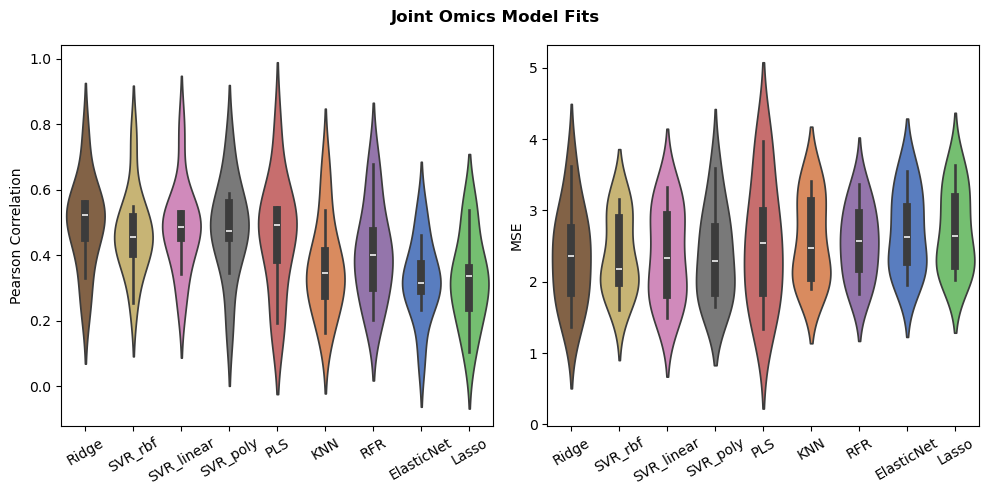

In [12]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))
order_map = dict(zip(metric_types, [model_order, model_order]))

palette = dict(zip(sorted(res.model_type.unique()), sns.color_palette("muted")))

for i, metric_type in enumerate(metric_types):
    # sort by mean of metric
    res.model_type = pd.Categorical(res.model_type, categories = order_map[metric_type], 
                               ordered = True)
    
    
    sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i], 
                  palette = palette)#,
#                    fill = False, inner = None)
    
#     sns.boxplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                 width=0.1, 
#                 color="black", showcaps=False, boxprops={'facecolor':'none'}, 
#                 whiskerprops={'linewidth':0.5}, ax = ax[i])
#     sns.stripplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                   alpha=0.5, jitter=True, dodge=True, ax = ax[i], color = 'black')
    
    ax[i].set_xlabel('')
    ax[i].set_ylabel(mmap[metric_type])
    
    xlabels = [x._text for x in ax[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, ax[i].get_xticks()))
    y, h = ax[i].get_ylim()[1], 0.05
    
    ax[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr_' + metric_type].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d_' + metric_type].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
            y_pos = y+(sig_counter*0.15)
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=1.01
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1

#     ax[i].grid(axis='y', linestyle='--', alpha=0.7)
fig.suptitle('Joint Omics Model Fits',
    fontweight='bold',  # Makes the text bold
)
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'all_models_joint.png'), 
            dpi=300, 
            bbox_inches="tight")  

For each metric (panels), violin plots are ordered by the best ranked model across folds. Each fold has the best model selected using optuna hyperparameter tuning. We observe the following: 

# Consensus model

Here, we simply want to assess consensus joint omics models' predictive performance, particularly relative to transcriptomics.  Thus, we'll take the top two models by each metric, and see how they perform as compared to the consensus model identified for transcriptomics (in [this notebook]( ../A_rna_prediction/03_predict_transcriptomics.ipynb)). Between Pearson correlation and MSE, the top 3 performing models are:
- SVR linear
- Ridge
- SVR RBF


In [10]:
def p_max(x):
    counts = Counter(x)
    most_common_count = counts.most_common(1)[0][1]
    return most_common_count / len(x)

def mode_or_mean(x):
    return statistics.mode(x) if p_max(x)>=0.5 else int(round(np.mean(x)))


In [39]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean'].values.ravel()

expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)

protein_cols = expr_protein.columns
rna_cols = expr_rna.columns

with open(os.path.join(data_path, 'processed', 'protein_cols.txt'), 'w') as f:
    for item in protein_cols:
        f.write(item + '\n')
        
with open(os.path.join(data_path, 'processed', 'rna_cols.txt'), 'w') as f:
    for item in rna_cols:
        f.write(item + '\n')

X_protein = X[protein_cols].values
X_rna = X[rna_cols].values


Let's get the consensus model for each of the top 3:

In [11]:
model_type = 'SVR_linear'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best_rna = []
n_features_best_protein = []
C_best = []
epsilon_best = []
for k, bp in enumerate(res_model.best_params):
    n_features_protein = int(bp.split(', ')[0].split(': ')[1])
    n_features_rna = int(bp.split(', ')[1].split(': ')[1])
    C = float(bp.split(', ')[2].split(': ')[1])
    epsilon = float(bp.split(', ')[3].split(': ')[1][:-1])

    n_features_best_protein.append(n_features_protein)
    n_features_best_rna.append(n_features_rna)
    C_best.append(C)
    epsilon_best.append(epsilon)    

    print('Fold: {}, RNA / protein features: {}/{}, C: {:4f}, epsilon: {:.4f}'.format(
        k, n_features_rna, n_features_protein, C, epsilon))
    
n_features_best_protein = mode_or_mean(n_features_best_protein)
n_features_best_rna = mode_or_mean(n_features_best_rna)
C_best = np.mean(C_best)
epsilon_best = np.mean(epsilon_best)

print('The consensus model has RNA / protein features: {}/{}, C: {:4f}, epsilon: {:.4f}'.format(
    n_features_best_rna, n_features_best_protein, C_best, epsilon_best)
     )

protein_pipeline = Pipeline([
    ("select_protein", ModalitySelector(modality="protein")),
    ("feature_selection_protein", ProteinFeatureSelector(method="top_residuals", n_features=n_features_best_protein)),
    ("mean_centering_protein", MeanCenterer()),  # Mean centering for protein data
])

# RNA-specific pipeline
rna_pipeline = Pipeline([
    ("select_rna", ModalitySelector(modality="rna")),
    ("feature_selection_rna", RNAFeatureSelector(method="top_residuals", n_features=n_features_best_rna)),
    ("mean_centering_rna", MeanCenterer()),  # Mean centering for RNA data
])

# Combine both pipelines
combined_pipeline = FeatureUnion([
    ("protein_pipeline", protein_pipeline),
    ("rna_pipeline", rna_pipeline),
])

best_steps = [
    ("feature_processing", combined_pipeline),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=C_best,
    epsilon=epsilon_best
)))
best_pipeline_svr_linear = Pipeline(best_steps)

write_pickled_object(best_pipeline_svr_linear, 
                    os.path.join(data_path, 'processed', 'best_model_svr_linear_joint.pickle'))
best_pipeline_svr_linear


SVR_linear
Fold: 0, RNA / protein features: 5000/250, C: 0.125604, epsilon: 1.0301
Fold: 1, RNA / protein features: 16371/500, C: 0.021449, epsilon: 0.4864
Fold: 2, RNA / protein features: 5000/1000, C: 0.000123, epsilon: 0.0349
Fold: 3, RNA / protein features: 16371/1000, C: 0.000121, epsilon: 0.0518
Fold: 4, RNA / protein features: 16371/5000, C: 2.593100, epsilon: 0.4104
Fold: 5, RNA / protein features: 5000/250, C: 18.053533, epsilon: 0.7895
Fold: 6, RNA / protein features: 16371/5000, C: 30.314188, epsilon: 0.4017
Fold: 7, RNA / protein features: 16371/1000, C: 7.147581, epsilon: 0.9619
Fold: 8, RNA / protein features: 5000/250, C: 0.039956, epsilon: 0.2470
Fold: 9, RNA / protein features: 16371/500, C: 0.062408, epsilon: 0.6018
The consensus model has RNA / protein features: 16371/1475, C: 5.835806, epsilon: 0.5016


,steps,"[('feature_processing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('protein_pipeline', ...), ('rna_pipeline', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,modality,'protein'
,method,'top_residuals'


In [41]:
model_type = 'Ridge'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best_rna = []
n_features_best_protein = []
n_features_best = []
alpha_best = []
for k,bp in enumerate(res_model.best_params):
    n_features_rna = int(bp.split(', ')[1].split(': ')[1])
    n_features_protein = int(bp.split(', ')[0].split(': ')[1])
    alpha = float(bp.split(', ')[2].split(': ')[1][:-1])
    
    n_features_best_rna.append(n_features_rna)
    n_features_best_protein.append(n_features_protein)
    alpha_best.append(alpha)
    
    print('Fold: {}, RNA / protein features: {}/{}, alpha: {:4f}'.format(k, n_features_rna, n_features_protein, alpha))


n_features_best_protein = mode_or_mean(n_features_best_protein)
n_features_best_rna = mode_or_mean(n_features_best_rna)
alpha_best = np.mean(alpha_best)

print('The consensus model has RNA / protein features: {}/{}, alpha: {:4f}'.format(
    n_features_best_rna, n_features_best_protein, C_best, alpha_best)
     )

protein_pipeline = Pipeline([
    ("select_protein", ModalitySelector(modality="protein")),
    ("feature_selection_protein", ProteinFeatureSelector(method="top_residuals", n_features=n_features_best_protein)),
    ("mean_centering_protein", MeanCenterer()),  # Mean centering for protein data
])

# RNA-specific pipeline
rna_pipeline = Pipeline([
    ("select_rna", ModalitySelector(modality="rna")),
    ("feature_selection_rna", RNAFeatureSelector(method="top_residuals", n_features=n_features_best_rna)),
    ("mean_centering_rna", MeanCenterer()),  # Mean centering for RNA data
])

# Combine both pipelines
combined_pipeline = FeatureUnion([
    ("protein_pipeline", protein_pipeline),
    ("rna_pipeline", rna_pipeline),
])

best_steps = [
    ("feature_processing", combined_pipeline),
]
best_steps.append(("model", Ridge(
    alpha  = alpha_best,
    random_state=random_state,
)))
best_pipeline_ridge = Pipeline(best_steps)


best_pipeline_ridge


Ridge
Fold: 0, RNA / protein features: 16371/5000, alpha: 62.073761
Fold: 1, RNA / protein features: 5000/500, alpha: 99.940588
Fold: 2, RNA / protein features: 16371/1000, alpha: 99.341655
Fold: 3, RNA / protein features: 16371/5000, alpha: 65.036292
Fold: 4, RNA / protein features: 16371/5000, alpha: 99.015427
Fold: 5, RNA / protein features: 5000/250, alpha: 99.712236
Fold: 6, RNA / protein features: 16371/5000, alpha: 71.170198
Fold: 7, RNA / protein features: 16371/5000, alpha: 70.380307
Fold: 8, RNA / protein features: 5000/250, alpha: 99.710437
Fold: 9, RNA / protein features: 5000/1000, alpha: 99.531251
The consensus model has RNA / protein features: 16371/5000, alpha: 5.835806


,steps,"[('feature_processing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('protein_pipeline', ...), ('rna_pipeline', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,modality,'protein'
,method,'top_residuals'


In [42]:
model_type = 'SVR_rbf'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best_rna = []
n_features_best_protein = []
C_best = []
epsilon_best = []
gamma_best = []
for k, bp in enumerate(res_model.best_params):
    n_features_rna = int(bp.split(', ')[1].split(': ')[1])
    n_features_protein = int(bp.split(', ')[0].split(': ')[1])
    C = float(bp.split(', ')[2].split(': ')[1])
    epsilon = float(bp.split(', ')[3].split(': ')[1])
    gamma = eval((bp.split(', ')[4].split(': ')[1][:-1]))
    
    n_features_best_rna.append(n_features_rna)
    n_features_best_protein.append(n_features_protein)
    C_best.append(C)
    epsilon_best.append(epsilon)
    gamma_best.append(gamma)
    
    print('Fold: {}, RNA / protein features: {}/{}, alpha: {:4f}'.format(k, n_features_rna, n_features_protein, alpha))


n_features_best_protein = mode_or_mean(n_features_best_protein)
n_features_best_rna = mode_or_mean(n_features_best_rna)
C_best = np.mean(C_best)
epsilon_best = np.mean(epsilon_best)
gamma_best = statistics.mode(gamma_best) 

print('The connsensus model has RNA / protein features: {}/{}, C: {:4f}, epsilon: {:.4f}, gamma: {}'.format(
    n_features_best_rna, n_features_best_protein, C_best, epsilon_best, gamma_best))

protein_pipeline = Pipeline([
    ("select_protein", ModalitySelector(modality="protein")),
    ("feature_selection_protein", ProteinFeatureSelector(method="top_residuals", n_features=n_features_best_protein)),
    ("mean_centering_protein", MeanCenterer()),  # Mean centering for protein data
])

# RNA-specific pipeline
rna_pipeline = Pipeline([
    ("select_rna", ModalitySelector(modality="rna")),
    ("feature_selection_rna", RNAFeatureSelector(method="top_residuals", n_features=n_features_best_rna)),
    ("mean_centering_rna", MeanCenterer()),  # Mean centering for RNA data
])

# Combine both pipelines
combined_pipeline = FeatureUnion([
    ("protein_pipeline", protein_pipeline),
    ("rna_pipeline", rna_pipeline),
])

best_steps = [
    ("feature_processing", combined_pipeline),
]
best_steps.append(("model", SVR(
    kernel='rbf',
    C=C_best,
    epsilon=epsilon_best,
    gamma = gamma_best
)))
best_pipeline_svr_rbf = Pipeline(best_steps)


best_pipeline_svr_rbf


SVR_rbf
Fold: 0, RNA / protein features: 16371/250, alpha: 99.531251
Fold: 1, RNA / protein features: 16371/250, alpha: 99.531251
Fold: 2, RNA / protein features: 16371/250, alpha: 99.531251
Fold: 3, RNA / protein features: 16371/250, alpha: 99.531251
Fold: 4, RNA / protein features: 10000/250, alpha: 99.531251
Fold: 5, RNA / protein features: 5000/250, alpha: 99.531251
Fold: 6, RNA / protein features: 16371/250, alpha: 99.531251
Fold: 7, RNA / protein features: 16371/500, alpha: 99.531251
Fold: 8, RNA / protein features: 16371/250, alpha: 99.531251
Fold: 9, RNA / protein features: 16371/1000, alpha: 99.531251
The connsensus model has RNA / protein features: 16371/250, C: 11.188702, epsilon: 0.0339, gamma: scale


,steps,"[('feature_processing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('protein_pipeline', ...), ('rna_pipeline', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,modality,'protein'
,method,'top_residuals'


In [43]:
best_pipelines = {
    'svr_linear': best_pipeline_svr_linear, 
    'svr_rbf': best_pipeline_svr_rbf, 
    'ridge': best_pipeline_ridge, 
#     'lasso': best_pipeline_lasso, 
#     'ridge': best_pipeline_ridge
}

In [14]:
# np.random.seed(random_state)
# outer_cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
# # n_synthetic = 1000
# # augment = False
# # res = {}

# results = []
# for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y))):
#     X_train_rna, X_test_rna = X_rna[train_idx], X_rna[test_idx]
#     X_train_protein, X_test_protein = X_protein[train_idx], X_protein[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
    
#     X_train = (X_train_protein, X_train_rna)
#     X_test = (X_test_protein, X_test_rna)
    
# #     # augment data
# #     if augment:
# #         synthetic_X, synthetic_y = mixup(X_train, y_train, n_synthetic = n_synthetic, alpha = 2, 
# #                                          random_state = random_state)
# #         X_train = np.concatenate((X_train, synthetic_X), axis = 0)
# #         y_train = np.concatenate((y_train, synthetic_y), axis = 0)
        
#     results_dict = {'fold': k}
    
#     for mod_type, best_pipeline in best_pipelines.items():
#         train_corr, test_corr, train_mse, test_mse = get_stats_best(best_pipeline, y_train, y_test, X_train, X_test)
        
#         # random y
#         y_train_rand = np.random.permutation(y_train)
#         res_y_rand = get_stats_best(best_pipeline, y_train_rand, y_test, X_train, X_test)
#         _, test_corr_y_rand, _, test_mse_y_rand = res_y_rand   
        
#         # random X
#         X_train_rand = tuple([X_train_[:, np.random.permutation(X_train_.shape[1])] for X_train_ in X_train])
#         res_X_rand = get_stats_best(best_pipeline, y_train, y_test, X_train_rand, X_test)
#         _, test_corr_X_rand, _, test_mse_X_rand = res_X_rand 
        
#         mod_dict = {
#             "train_corr_" + mod_type: train_corr,
#             "test_corr_" + mod_type: test_corr,
#             'train_mse_' + mod_type: train_mse, 
#             'test_mse_' + mod_type: test_mse,
            
#             "random_y_test_corr_" + mod_type: test_corr_y_rand,
#             'random_y_test_mse_' + mod_type: test_mse_y_rand,
            
#             "random_X_test_corr_" + mod_type: test_corr_X_rand,
#             'random_X_test_mse_' + mod_type: test_mse_X_rand,
            
            
#         }
#         results_dict = {**results_dict, **mod_dict}

#     results.append(results_dict)
#     best_res_df = pd.DataFrame(results)
# best_res_df.to_csv(os.path.join(data_path, 'processed', 'joint_consensus_performance.csv'))

best_res_df=pd.read_csv(os.path.join(data_path, 'processed', 'joint_consensus_performance.csv'), 
                       index_col = 0)


Get the Cohen's D and p-value between the linear consensus SVR here and that run on the full transcriptomics dataset:

In [38]:
# tbrd = pd.read_csv(os.path.join(data_path, 'processed', 'transcriptomics_consensus_performance.csv'), 
#                          index_col = 0)

# a = best_res_df.test_corr_svr_linear
# b = tbrd.test_corr_svr_linear
# pval = stats.mannwhitneyu(a,b, alternative = 'two-sided').pvalue
# cd = cohen_d(a,b)

# pval
# cd

In [45]:
model_types_ = ['ridge', 'svr_linear', 'svr_rbf']
metric_types_ = ['test_mse', 'test_corr']
best_res_df_ = best_res_df[
    ['fold'] + ['_'.join(i) for i in itertools.product(metric_types_, model_types_)]
]

best_res_df_ = (
    best_res_df_
        .melt(id_vars='fold', value_name='value')
        .assign(
            metric=lambda x: x.variable.str.split('_').str[:2].str.join('_'),
            model_type=lambda x: x.variable.str.split('_').str[2:].str.join('_')
        )
        .pivot(index=['fold', 'model_type'], columns='metric', values='value')
        .reset_index()[['fold', 'model_type', 'test_mse', 'test_corr']]
)

rank_order = aggregate_ranks(
    opt_res=best_res_df_.groupby('model_type', observed = True)[['test_mse', 'test_corr']].median().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'higher'
    },
    method = 'median'
)

model_order = rank_order.model_type.tolist()
rank_order


metric,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,ridge,2.155323,0.500086,1.0,2.0,1.5,1.0
1,svr_rbf,2.375667,0.520181,3.0,1.0,2.0,2.0
2,svr_linear,2.244160,0.498098,2.0,3.0,2.5,3.0


In [46]:
rank_order_std = aggregate_ranks(
    opt_res=best_res_df_.groupby('model_type', observed = True)[['test_mse', 'test_corr']].std().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'lower'
    },
    method = 'median'
)

rank_order_std


metric,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,svr_linear,0.814280,0.147101,2.0,1.0,1.5,1.5
1,svr_rbf,0.791792,0.168478,1.0,2.0,1.5,1.5
2,ridge,0.908482,0.168642,3.0,3.0,3.0,3.0


While Ridge has a higher median performance for both performance, linear SVR hs a smaller STD for both metrics. And the perfromance difference is not significant:

In [53]:
# for model_type in best_pipelines.keys():
#     print('The mean Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].mean()))
#     print('The median Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].mean()))
#     print('The Pearson correlation standard deviation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].std()))



#     print('The mean MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].mean()))
#     print('The median MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].mean()))
#     print('The MSE standard deviation for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].std()))

#     print('----------')

### Assessment 1

First, let's test whether each consensus model performs better than random:

In [47]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
# split by metric type
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]

viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}
mmap = dict(zip(['Pearson Correlation', 'Mean Squared Error'], ['corr', 'mse']))
model_map = dict(zip(['ridge', 'svr_rbf', 'svr_linear'],
                    ['Ridge', 'RBF SVR', 'Linear SVR']))

unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

In [48]:
shared_element = 'Linear SVR - Transcriptomics'
# [
#     (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
#     for elem in mod_combs
# ]

In [68]:
def get_stats(viz_df, stat_type, model_type, metric_type):
    res_stats = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d'])
    mod_combs = list(itertools.combinations((viz_df['Model Type'].unique()), 2))
    
    if stat_type == 'random':
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Randomly') == 1]
        
        alternative = 'two-sided'
#         if metric_type == 'Pearson Correlation':
#             alternative = 'greater'
#         elif metric_type == 'Mean Squared Error':
#             alternative = 'less'
        
        # reorder
        shared_element = model_map[model_type]
        mod_combs = [
            (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
            for elem in mod_combs
        ]
    elif stat_type == 'within':
        alternative = 'two-sided'
    elif stat_type == 'transcriptomics':     
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Transcriptomics') == 1]
#         alternative = 'less' #'one-sided'#'two-sided'
        
        if metric_type == 'Pearson Correlation': 
            alternative = 'less'
        elif metric_type == 'Mean Squared Error':
            alternative = 'greater'
        
        # reorder
        shared_element = 'Linear SVR - Transcriptomics'
        mod_combs = [
            (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
            for elem in mod_combs
        ]
        

    for mc in mod_combs:
        a = viz_df[viz_df['Model Type'] == mc[0]].iloc[:, 1]
        b = viz_df[viz_df['Model Type'] == mc[1]].iloc[:, 1]

        pval = stats.mannwhitneyu(a,b, alternative = alternative).pvalue
        cd = cohen_d(a,b)

        res_stats.loc[res_stats.shape[0], :] = [mc, pval, cd]

    _, fdr, _, _ = multipletests(res_stats.pval.values, method='fdr_bh')
    res_stats['fdr'] = fdr
    
    return res_stats, mod_combs

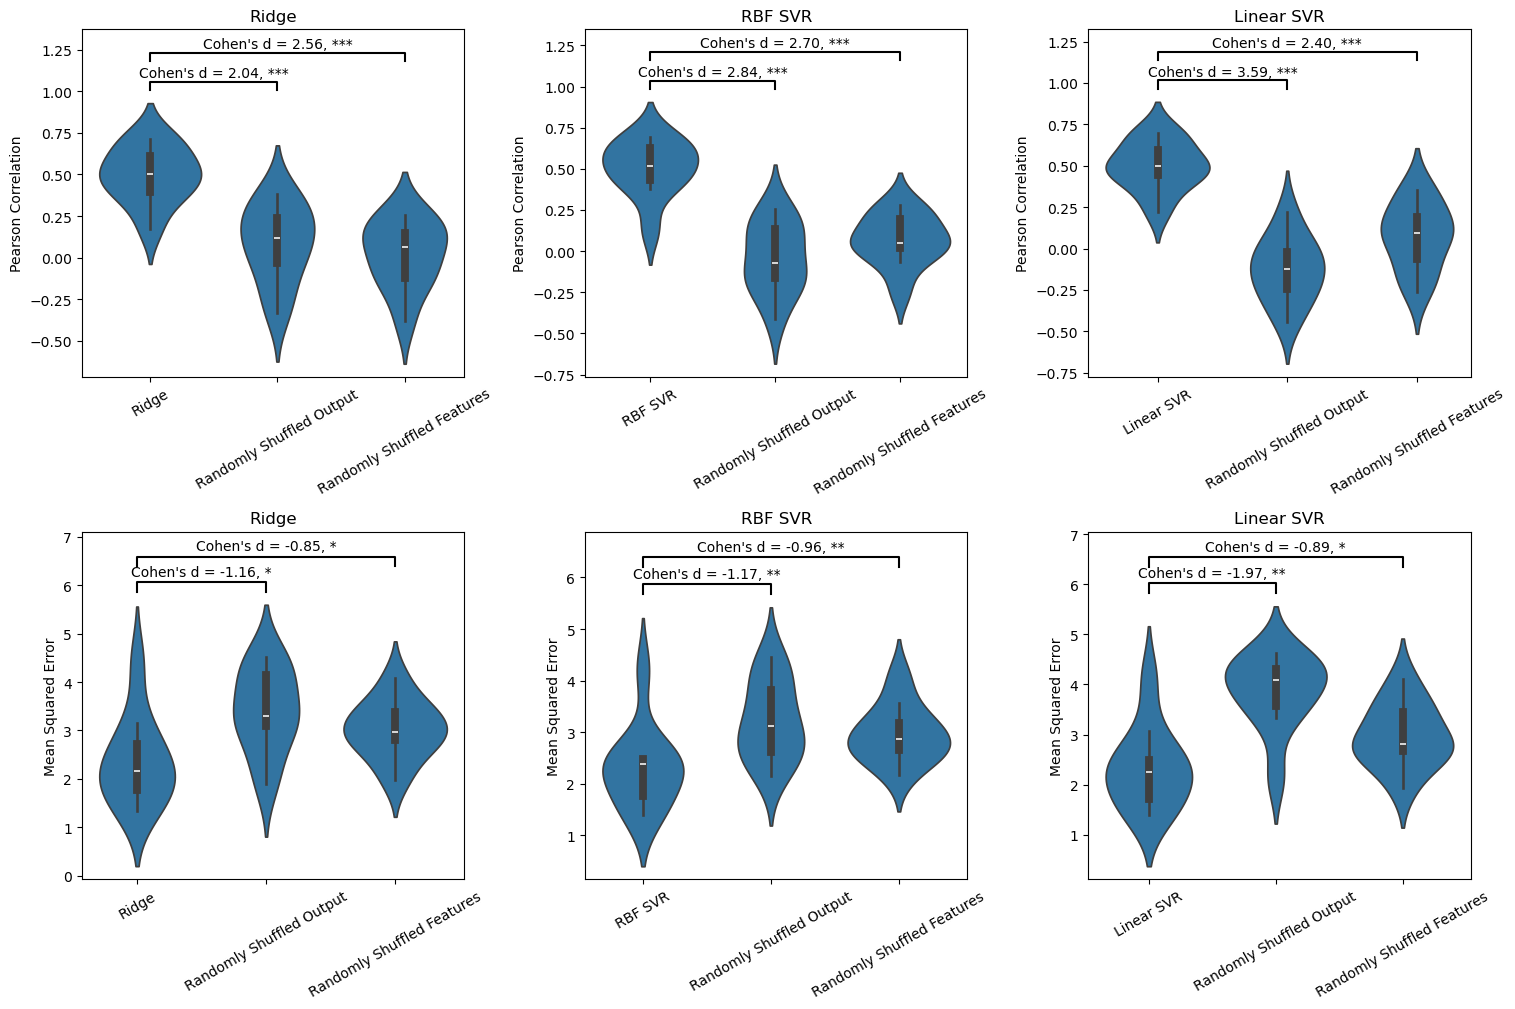

In [62]:
ncols = len(best_pipelines)
nrows = 2 # two metrics
fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols*5.1, nrows*5.1))

for j, model_type in enumerate(model_order):
#     break
    
    for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
        viz_df = viz_df_[[col for col in viz_df_ if model_type in col]]
        viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

        # some formatting
        viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type], 
                                  'random_y_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Output', 
                                 'random_X_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Features'})
        
        # may want to do this across all comparisons simultaneously
        res_stats, mod_combs = get_stats(viz_df, stat_type = 'random', model_type = model_type, metric_type = metric_type)

        sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i, j])
        ax[i, j].set_title(model_map[model_type])
        ax[i, j].set_xlabel('')
        
        xlabels = [x._text for x in ax[i, j].get_xticklabels()]
        ax[i, j].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
        
        x_pos = dict(zip(xlabels, ax[i,j].get_xticks()))

        y_lower, y = ax[i,j].get_ylim()
        h = unit_map['h'][metric_type]
        
        # significance
        sig_counter = 0
        for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
            x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

            fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
            cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

            significance = "N.S."
            if fdr <= 1e-4:
                significance = "****"
            elif fdr <= 0.001:
                significance = "***"
            elif fdr <= 0.01:
                significance = "**"
            elif fdr <= 0.1:
                significance = "*"

            if significance != 'N.S.':
    #             y_pos = y+(sig_counter*0.15)
                y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
                ax[i,j].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                        [y_pos, y_pos+h, y_pos+h, y_pos], 
                        lw=1.5, c='black')
                y_pos*=unit_map['y_pos_scale'][metric_type]
                ax[i,j].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                        ha='center', va='bottom', fontsize=10)
                sig_counter += 1
        if sig_counter != 0:
            ax[i,j].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'random_joint.png'), 
            dpi=300, 
            bbox_inches="tight")  


All models perform better than random.

### Assessment 2

Next, let's test whether there is a difference in model performance across the consensus models:

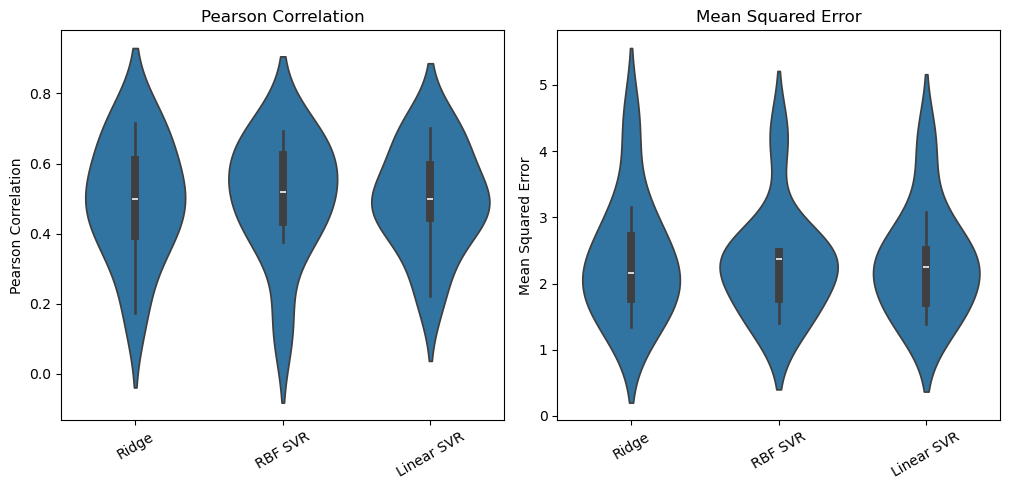

In [27]:
ncols = 2
fig, ax = plt.subplots(ncols = ncols, figsize = (ncols*5.1, 5))

am = {'Pearson Correlation': False, 'Mean Squared Error': True}

for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
    viz_df = viz_df_[[col for col in viz_df_ if 'random' not in col]]


    viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type] for model_type in best_pipelines.keys()})
#     rank_ordered_models = viz_df.groupby(['Model Type']).std()[metric].sort_values(ascending = True).index.tolist()
#     viz_df['Model Type'] = pd.Categorical(viz_df['Model Type'], 
#                                           categories = rank_ordered_models, 
#                                           ordered = True)
    
    
    # may want to do this across all comparisons simultaneously
    res_stats, mod_combs = get_stats(viz_df, stat_type = 'within', 
                                     model_type = None, 
                                     metric_type = None)
    viz_df['Ordered Model Type'] = pd.Categorical(viz_df['Model Type'], 
                                          categories = [model_map[m_] for m_ in model_order], 
                                          ordered = True)

    sns.violinplot(data = viz_df, x = 'Ordered Model Type', y = metric_type, ax = ax[i])
    ax[i].set_title(metric_type)
    ax[i].set_xlabel('')

    xlabels = [x._text for x in ax[i].get_xticklabels()]
    ax[i].set_xticklabels(xlabels, 
                      rotation=30, 
                     ha = 'center')

    x_pos = dict(zip(xlabels, ax[i].get_xticks()))

    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric_type]

    # significance
    sig_counter = 0
    for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"

        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                    [y_pos, y_pos+h, y_pos+h, y_pos], 
                    lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric_type]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'consensus_joint.png'), 
            dpi=300, 
            bbox_inches="tight")  



In [28]:
res_stats

,comparison,pval,cohen_d,fdr
0,"(Linear SVR, RBF SVR)",0.96985,0.026456,0.96985
1,"(Linear SVR, Ridge)",0.909722,-0.042866,0.96985
2,"(RBF SVR, Ridge)",0.909722,-0.068329,0.96985


There is no significant difference in consensus model performance by either metric.

### Assessment 3

Finally, let's test whether there is a difference in these model performances vs the consensus model identified in transcriptomics. We use the consensus linear SVR as outlined in [this notebook](../A_rna_prediction/03_predict_transcriptomics.ipynb). 

We use the results from the power analysis [here](../A_rna_prediction/05_power_analysis_transcriptomics.ipynb), selecting the run with the number of samples equal to the number of samples available to proteomics. One caveat here is that the transcriptomic results were note calculated on the same set of folds as proteomics. However, given the bootstrapping of 100 subsets per fold, results should be consistent. 

In [59]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean'].values.ravel()


transcriptomics_power = pd.read_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics_linear_svr.csv'), index_col = 0)

n_splits = 10
joint_train_size = int(np.round(y.shape[0] * (1 - (1/n_splits))))
transcriptomics_res = transcriptomics_power[transcriptomics_power.train_sample_size == joint_train_size]


In [60]:
transcriptomics_res.test_corr.mean()

0.42530525991531215

In [61]:
transcriptomics_res.test_corr.median()

0.430008317612135

In [62]:
transcriptomics_res.test_corr.std()

0.11792378592055928

In [63]:
transcriptomics_res.test_mse.mean()

2.0944892818190137

In [64]:
transcriptomics_res.test_mse.std()

0.4065879332195834

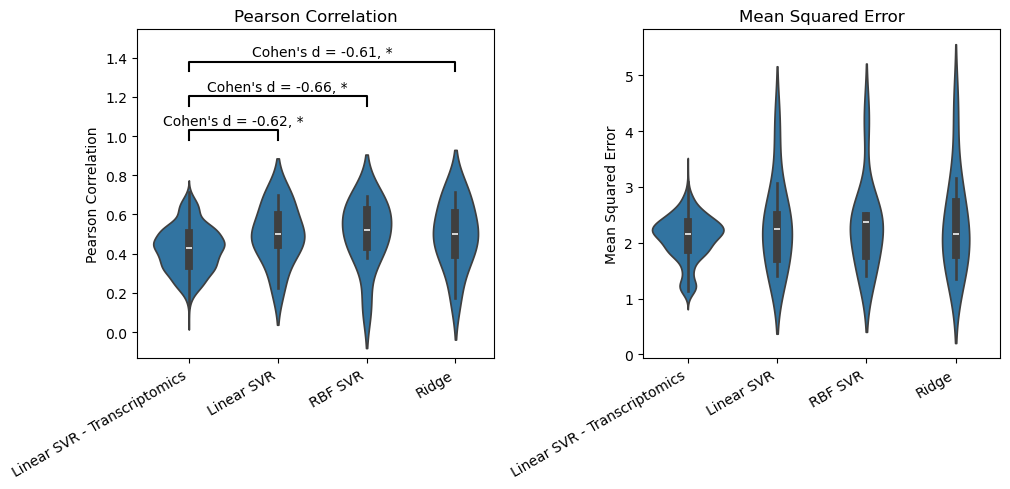

In [70]:
ncols = 2
fig, ax = plt.subplots(ncols = ncols, figsize = (ncols*5.1, 5))
res_stats_all = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d', 'fdr'])

for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
    viz_df = viz_df_[[col for col in viz_df_ if 'random' not in col]]
    viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type] for model_type in best_pipelines.keys()})

    viz_df_rna = pd.DataFrame(data = {'Model Type': 'Linear SVR - Transcriptomics', 
                                      metric_type: transcriptomics_res['test_' + mmap[metric_type]]}
                             ).reset_index(drop = True)
    viz_df = pd.concat([viz_df_rna, viz_df], axis = 0)
    
    res_stats, mod_combs = get_stats(viz_df, stat_type = 'transcriptomics', 
                                     model_type = None, 
                                     metric_type = metric_type)
    res_stats_ = res_stats.copy()
    res_stats['metric'] = metric_type
    res_stats_all = pd.concat([res_stats_all, res_stats], axis = 0)

    sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i])
    ax[i].set_title(metric_type)
    ax[i].set_xlabel('')

    xlabels = [x._text for x in ax[i].get_xticklabels()]
    ax[i].set_xticklabels(xlabels, 
                      rotation=30, 
                     ha = 'right')

    x_pos = dict(zip(xlabels, ax[i].get_xticks()))

    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric_type]

    # significance
    sig_counter = 0
    for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"

        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                    [y_pos, y_pos+h, y_pos+h, y_pos], 
                    lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric_type]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'consensus_joint_comparison.png'), 
            dpi=300, 
            bbox_inches="tight")  

res_stats_all.to_csv(os.path.join(data_path, 'interim', 'joint_consensus_comparison_statistics.csv'))


There is no difference in model performance by MSE. However, the transcriptomics only consensus model performs worse than all the consensus joint models as measured by Pearson correlation. Altgoether, this indicates that the combined consideration of transcriptomics of proteomics enhances model predictive power as compared to considering transcriptomics alone. 

Quantitatively, while the transcriptomics only linear SVR achieved a mean Pearson correlation of 0.43 at the sample size of 247, the joint transcriptomics + proteomics model achieved a mean Pearson correlation between 0.50-0.51 for the consensus models. That's approximately 6 percentage points more variance explained (R^2 of 0.191 vs ~0.25 respectively).

Since there is no significant difference in consensus model performances between model types within the joint omics, and since the linear SVR demonstrated the smallest standard deviation across folds and is consistent with the consensus model selected for transcriptomics, we will proceed with this model.

In [71]:
fns = [os.path.join(data_path, 'figures', 'consensus_joint_comparison.png'), 
      os.path.join(data_path, 'figures', 'consensus_joint.png'), 
      os.path.join(data_path, 'figures', 'random_joint.png'), 
       os.path.join(data_path, 'figures', 'all_models_joint.png')
      ]

for fn in fns:
    cmd = 'scp hmbaghda@orcd-login001.mit.edu:' + fn
    cmd += ' Downloads/figures/.'
    print(cmd)

scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential/figures/consensus_joint_comparison.png Downloads/figures/.
scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential/figures/consensus_joint.png Downloads/figures/.
scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential/figures/random_joint.png Downloads/figures/.
scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential/figures/all_models_joint.png Downloads/figures/.
